In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+995cec829e 	w_2023_29 setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
import logging

import sys
sys.path.append('/sdf/home/a/abrought/bin')
from SpotAnalysis import *

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

repo_path = "/repo/main"

butler = Butler(repo_path)
registry = butler.registry

## R03-S12

In [3]:
sensor = "R03_S12"
detector = 23

# Butler repository
outdir = "/sdf/home/a/abrought/run5/BF/data/2023-07-19-improvedbkgremoval/"

# Retrieve data
data_uncorrected = readData( #outdir + "data_13247_R03_S12_2023-02-02T15:17:36_680nm_uncorrected.pkl", \
                             outdir + "data_13248_R03_S12_2023-08-02T03:27:39_680nm_uncorrected.pkl", \
                             expstoremove=1)

Removing SEQNUMs: 
221 21 321 142 

File 1
5.0s, 27 images
10.0s, 30 images
15.0s, 37 images
20.0s, 40 images
25.0s, 40 images
30.0s, 31 images
35.0s, 30 images
40.0s, 30 images
45.0s, 30 images
50.0s, 30 images


 325


Text(0, 0.5, '$\\mu\\;/\\;\\Delta T$')

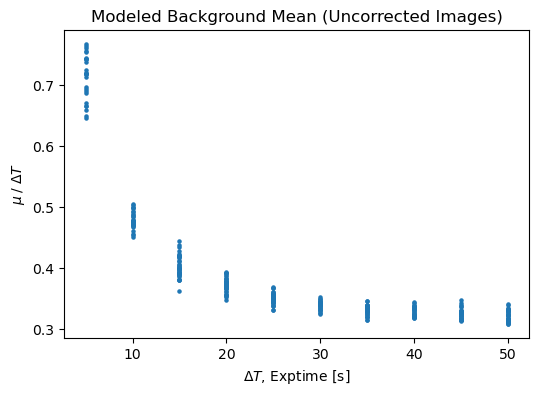

In [4]:
plt.figure(figsize=(6,4))
plt.scatter(data_uncorrected['exptime'],data_uncorrected['max_bkg']/data_uncorrected['exptime'], s=5)
plt.title("Modeled Background Mean (Uncorrected Images)")
plt.xlabel("$\Delta T$, Exptime [s]")
plt.ylabel("$\mu\;/\;\Delta T$")

#plt.figure(figsize=(6,4))
#plt.scatter(data_corrected['exptime'],data_corrected['mean_bkg']/data_corrected['exptime'], s=5)
#plt.title("Modeled Background Mean (Corrected Images)")
#plt.xlabel("$\Delta T$, Exptime [s]")
#plt.ylabel("$\mu\;/\;\Delta T$")

## Example image

In [5]:
def remove_background(image, exptime):
    
    def interpolate_background(array):
        array[array==0] = np.nan
        x = np.arange(0, array.shape[1])
        y = np.arange(0, array.shape[0])
        #mask invalid values
        array = np.ma.masked_invalid(array)
        xx, yy = np.meshgrid(x, y)
        #get only the valid values
        x1 = xx[~array.mask]
        y1 = yy[~array.mask]
        newarr = array[~array.mask]

        interpolated_image = interpolate.griddata((x1, y1), newarr.ravel(), (xx, yy), method='nearest')

        return interpolated_image

    from astropy.stats import SigmaClip
    from photutils.background import MedianBackground, SExtractorBackground
    

    
    # First pass to get Background estimate
    sigmaclip = SigmaClip(sigma=5.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, (65,65), filter_size=(5, 5), 
                       sigma_clip=sigmaclip, 
                       bkg_estimator=bkg_estimator)

    
    # Second pass ignoring spots pixels
    diff = image - bkg.background
    #coverage_mask = sc(diff, sigma=3, masked=True)
    from astropy.stats import sigma_clip
    coverage_mask = sigma_clip(diff, sigma=5, grow=2.0,maxiters=5, masked=True).mask

    del diff
    bkg = Background2D(image, (65, 65), filter_size=(5, 5), 
                       sigma_clip=None, 
                       bkg_estimator=bkg_estimator, 
                       coverage_mask=coverage_mask)
    
    # Interpolate over spot regions (coverage mask area)
    new_bkg = interpolate_background(bkg.background)
    
    return new_bkg


Text(0.5, 1.0, 'Image Slice @ Row #3000')

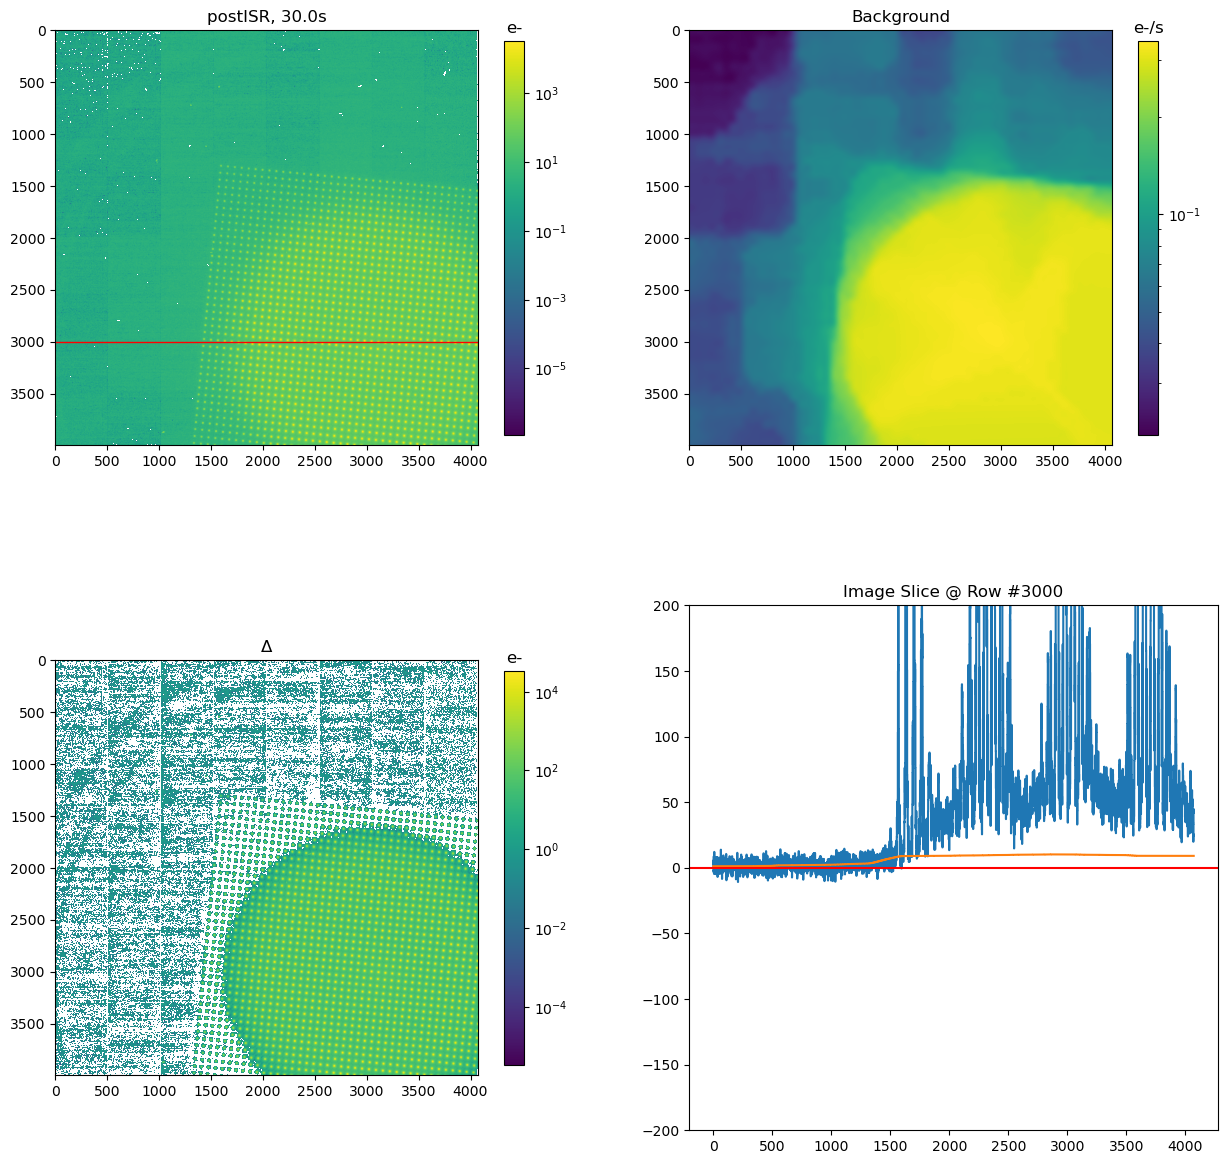

In [12]:
import matplotlib
#from scipy.interpolate import interpn
from scipy import interpolate

col = ["u/abrought/BF/2023.07.19/run_13248/R03-S12/uncorrected"]
subbutler = Butler("/repo/main", collections=col)
subregistry = subbutler.registry

datasetRefs = list(subregistry.queryDatasets(datasetType="gridSpotSrc", collections=col))
#print(len(datasetRefs))


#for ind, ref in enumerate(datasetRefs):
#    #ref = datasetRefs[ind]
#    print(ind)
#    raw = subbutler.get("raw",dataId=ref.dataId)
#    md = raw.getMetadata()
#    exptime = md["EXPTIME"]
#    if exptime == 15.:
#        aref = ref
#        break


aref = datasetRefs[23]
raw = subbutler.get("raw",dataId=aref.dataId)
md = raw.getMetadata()
exptime = md["EXPTIME"]

fig, axs = plt.subplots(2,2, figsize=(15,15))
# Get the postISR image
postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
gridfit = subbutler.get("gridSpotSrc",dataId=aref.dataId)
x0 = gridfit.getMetadata()['GRID_X0']
y0 = gridfit.getMetadata()['GRID_X0']
theta = gridfit.getMetadata()['GRID_THETA']


image = postisr.getImage().getArray()
im1 = axs[0][0].imshow(image, norm=matplotlib.colors.LogNorm())
axs[0][0].axhline(3000, color="red", linewidth=1, linestyle="-")
axs[0][0].set_title("postISR, " + str(exptime) + "s")
clb = plt.colorbar(im1, ax=axs[0][0], shrink=.75)
clb.ax.set_title('e-')

bkg = remove_background(image, exptime)

im2 = axs[0][1].imshow(bkg/exptime, norm=matplotlib.colors.LogNorm())
axs[0][1].set_title("Background")
clb = plt.colorbar(im2, ax=axs[0][1], shrink=.75)
clb.ax.set_title("e-/s")

im3 = axs[1][0].imshow(image - bkg, norm=matplotlib.colors.LogNorm())
axs[1][0].set_title("$\Delta$")
clb = plt.colorbar(im3, ax=axs[1][0], shrink=.75)
clb.ax.set_title("e-")


axs[1][1].plot(image[3000,:], drawstyle='steps-mid')
axs[1][1].plot(bkg[3000,:], drawstyle='steps-mid')
#axs[1][1].set_yscale("log")
axs[1][1].set_ylim(-200,200.)
axs[1][1].axhline(0.0, color="red")
axs[1][1].set_title("Image Slice @ Row #3000" )


Text(0.5, 1.0, 'Image Slice @ Row #3000')

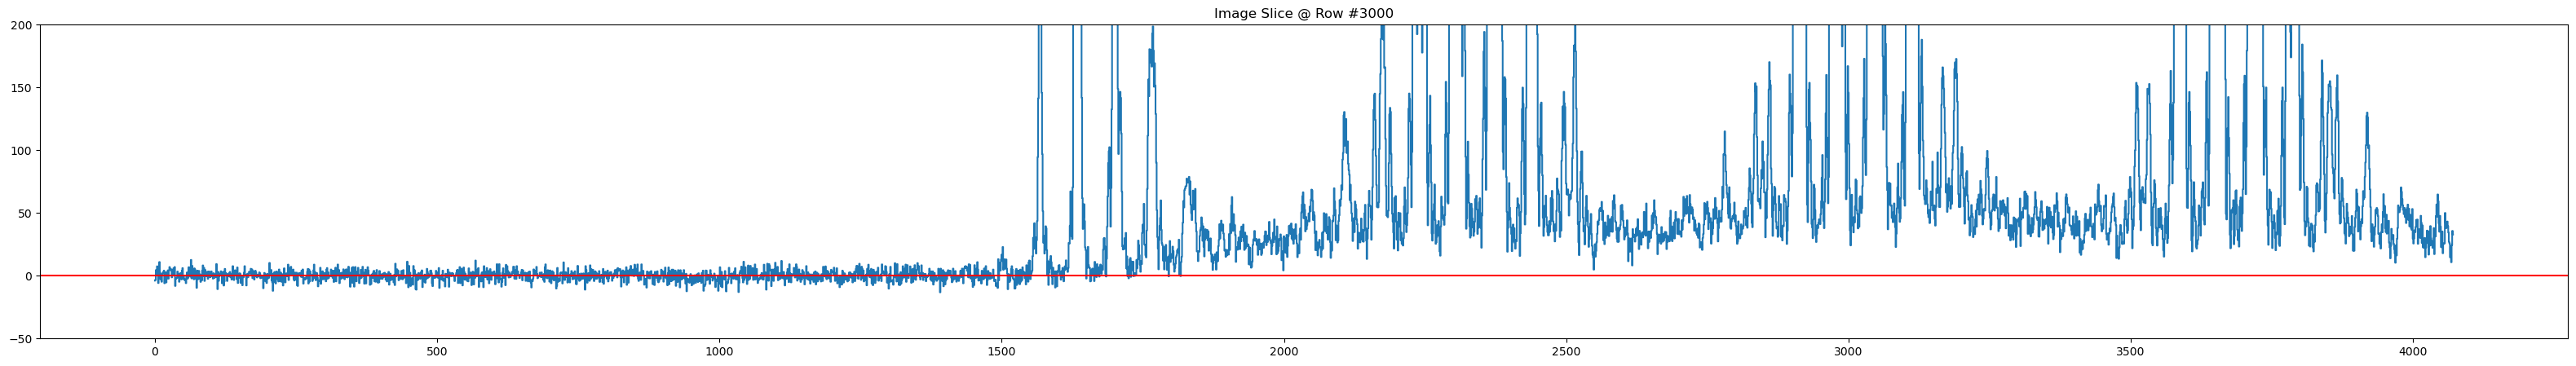

In [13]:
plt.figure(figsize=(40,5))
plt.plot(image[3000,:] - bkg[3000,:], drawstyle='steps-mid')
#plt.plot(bkg.background[1000,:], drawstyle='steps-mid')
#axs[1][1].set_yscale("log")
plt.ylim(-50,200)
#plt.xlim(1500,4000)
plt.axhline(0.0, color="red")
plt.title("Image Slice @ Row #3000" )

In [8]:
print(np.max(bkg))

3.8203047228745146


In [9]:
11.99/5

2.398

In [11]:
inds = []
for num, aref in enumerate(datasetRefs):
    if len(inds)==25:
        break
    aref = datasetRefs[num]
    raw = subbutler.get("raw",dataId=aref.dataId)
    exptime = raw.getMetadata()["EXPTIME"]
    if exptime == 30:
        inds.append(num)
        print(num, exptime)

23 30.0
29 30.0


KeyboardInterrupt: 

In [ ]:
inds

In [ ]:
import matplotlib
#from scipy.interpolate import interpn
from scipy import interpolate

col = ["u/abrought/BF/2023.07.19/run_13248/R03-S12/uncorrected"]
subbutler = Butler("/repo/main", collections=col)
subregistry = subbutler.registry

datasetRefs = list(subregistry.queryDatasets(datasetType="gridSpotSrc", collections=col))

bkgs = []
for i,ind in enumerate(inds):
    print(f"{i+1}/{len(inds)}")
    aref = datasetRefs[ind]

    # Get the postISR image
    postisr = subbutler.get("postISRCCD",dataId=aref.dataId)

    image = postisr.getImage().getArray()

    bkg = remove_background(image, 30.)

    bkgs.append(np.max(bkg))

print("Done!")

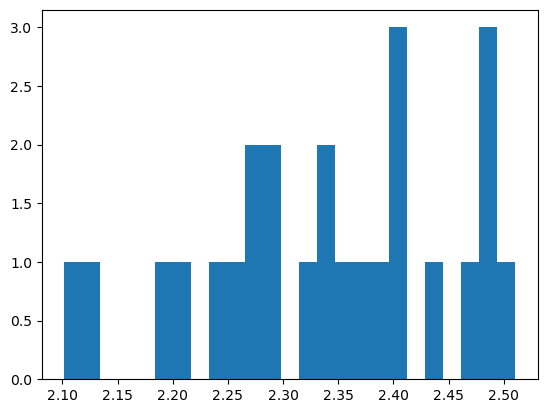

In [66]:
# 5s distribution
_=plt.hist(np.asarray(bkgs)/5., 25)

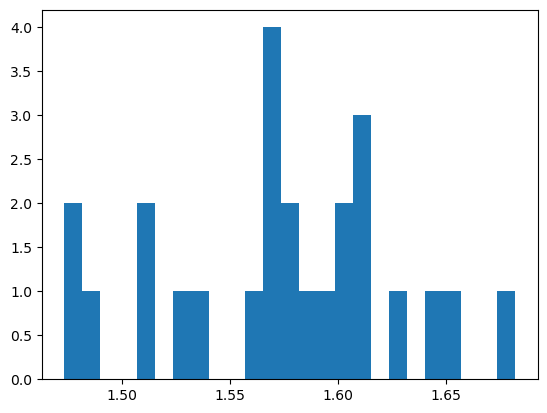

In [61]:
# 30s distribution
_=plt.hist(np.asarray(bkgs)/30., 25)